# Loading Kernel and Libraries

In [1]:
# Initiate Spark

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
6,application_1685659991689_0007,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
sc.install_pypi_package('torch')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import boto3

# Time Series Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Loading the Data

In [4]:
# Secondary School
train_ids = ['344765', '308201', '338557', '343166', '316447',
             '313251', '316061', '338835', '331293', '309986']
test_id = '325744'

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
# Loading Training Office School
for idx, train_id in enumerate(train_ids):
    energy = spark.read.parquet(
        f's3://nrel-pds-building-stock/comstock/athena/2020/comstock_v1/'
        f'state/upgrade=88/state=36/{train_id}-88.parquet'
    ).cache()

    # Clean up the dataframe
    energy_ny = energy.toDF(*(c.replace('.', '_') for c in energy.columns))
    ts_energy = (energy_ny.select(['timestamp',
                                   'out_electricity_total_energy_consumption']))

    # Convert to Pandas
    df_energy = ts_energy.toPandas()

    # Convert timestamp column to datetime
    df_energy['timestamp'] = pd.to_datetime(df_energy['timestamp'])

    # Rename actual consumption
    df_energy = df_energy.rename(
        columns={'out_electricity_total_energy_consumption': 'Actual'})

    # Create dataframe grouped by days
    df_day = df_energy.groupby(df_energy['timestamp'].dt.date).mean()
    df_day.index = pd.to_datetime(df_day.index)
    
    df_day[train_id] = df_day.shift(1).fillna(0)
    df_day = df_day.drop(columns='Actual')
    
    # Create the database
    if idx == 0:
        df_ts = df_day.copy()
    else:
        df_ts[train_id] = df_day[train_id]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Preprocessing

In [6]:
energy = spark.read.parquet(
    f's3://nrel-pds-building-stock/comstock/athena/2020/comstock_v1/'
    f'state/upgrade=88/state=36/{test_id}-88.parquet'
).cache()

# Clean up the dataframe
energy_ny = energy.toDF(*(c.replace('.', '_') for c in energy.columns))
ts_energy = (energy_ny.select(['timestamp',
                               'out_electricity_total_energy_consumption']))

# Convert to Pandas
df_energy = ts_energy.toPandas()

# Convert timestamp column to datetime
df_energy['timestamp'] = pd.to_datetime(df_energy['timestamp'])

# Rename actual consumption
df_energy = df_energy.rename(
    columns={'out_electricity_total_energy_consumption': 'y'})

# Create dataframe grouped by days
df_day = df_energy.groupby(df_energy['timestamp'].dt.date).mean()
df_day.index = pd.to_datetime(df_day.index)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
# Create a features of shifted values
ts = pd.DataFrame()
ts['y'] = df_day[['y']]

# Lookback window size 
window_size = 30

# Create new columns of different lookback period
for w in range(window_size):
    ts['y-' + str(w + 1)] = df_day[['y']].shift(w + 1)

# Adjust dataframe to remove NaN
ts = ts[window_size:]

# Add categorical labels for month and day of week
ts['month-of-year'] = ts.index.month
ts['day-of-week'] = ts.index.dayofweek  # Monday start

# Concat TS of other bldgs
df_final = pd.concat([ts, df_ts['2012-01-31':]], axis=1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
# Train-Val-Test dates
train_end  = '2012-09-30'
test_start = '2012-10-01'

# Train-Test split
df_train = df_final[:train_end]
df_test = df_final[test_start:]
x_train = df_train.drop(['y'], axis=1).to_numpy()
y_train = df_train[['y']].to_numpy()
x_test = df_test.drop(['y'], axis=1).to_numpy()
y_test = df_test[['y']].to_numpy()

# Fit Scaler on the training set
scaler_x = StandardScaler().fit(x_train)
scaler_y = StandardScaler().fit(y_train)

# Z-score normalization
x_train = scaler_x.transform(x_train)
y_train = scaler_y.transform(y_train)
x_test = scaler_x.transform(x_test)
y_test = scaler_y.transform(y_test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Random Forest

In [9]:
# Results
df_mae_results = pd.DataFrame()
param_list = []
scores = []

# Param grid
n_estimators = [100, 200, 300]
max_depth = [3, 5, 10, 20, 50]
grid = list(itertools.product(n_estimators, max_depth))

# Grid search
for param in grid:
    params = {
        'n_estimators': param[0],
        'max_depth': param[1],
        'random_state': 143
        }
    
    model = RandomForestRegressor(**params)
    
    # Fit model
    model.fit(x_train, y_train.ravel())
    
    # Evaluate
    y_pred = model.predict(x_test)
    y_pred = scaler_y.inverse_transform(y_pred[..., np.newaxis])
    y_true = scaler_y.inverse_transform(y_test)
    
    # Store results
    param_list.append(str(params))
    scores.append(mean_absolute_error(y_true, y_pred))

# Compile results 
df_mae_results['Params'] = param_list
df_mae_results['Scores'] = scores
df_mae_results.sort_values(by='Scores', inplace=True)

# Get model the best model
best_params = eval(df_mae_results.iloc[0, 0])
model = RandomForestRegressor(**best_params)
model.fit(x_train, y_train.ravel())
y_pred = model.predict(x_test)
y_pred_rf = scaler_y.inverse_transform(y_pred[..., np.newaxis])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Gradient Boost

In [10]:
# Results
df_mae_results = pd.DataFrame()
param_list = []
scores = []

# Param grid
n_estimators = [100, 200]
max_depth = [3, 5, 7]
max_features = [0.5, 0.7, 0.9]
learning_rate = [0.01, 0.1, 1]
grid = list(itertools.product(n_estimators, max_depth, max_features, learning_rate))

# Grid search
for param in grid:
    params = {
        'n_estimators': param[0],
        'max_depth': param[1],
        'max_features': param[2],
        'learning_rate': param[3],
        'random_state': 143
        }
    
    model = GradientBoostingRegressor(**params)
    
    # Fit model
    model.fit(x_train, y_train.ravel())
    
    # Evaluate
    y_pred = model.predict(x_test)
    y_pred = scaler_y.inverse_transform(y_pred[..., np.newaxis])
    y_true = scaler_y.inverse_transform(y_test)
    
    # Store results
    param_list.append(str(params))
    scores.append(mean_absolute_error(y_true, y_pred))

# Compile results 
df_mae_results['Params'] = param_list
df_mae_results['Scores'] = scores
df_mae_results.sort_values(by='Scores', inplace=True)

# Get model the best model
best_params = eval(df_mae_results.iloc[0, 0])
model = GradientBoostingRegressor(**best_params)
model.fit(x_train, y_train.ravel())
y_pred = model.predict(x_test)
y_pred_gb = scaler_y.inverse_transform(y_pred[..., np.newaxis])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# MLP (Multi-Layer Perceptron)

In [11]:
# Convert to torch tensors
x_train_torch = torch.tensor(x_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32)
x_test_torch = torch.tensor(x_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32)

# Create Data Loaders
batch_size = 1
train_ds = TensorDataset(x_train_torch, y_train_torch)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
test_ds = TensorDataset(x_test_torch, y_test_torch)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
# MLP Class time series forecaster
class mlp_forecaster(nn.Module):
    # Initialize Layers
    def __init__(self, in_size, h1_size, h2_size, h3_size, out_size):
        super().__init__()
        self.layer1 = nn.Linear(in_size, h1_size)
        self.layer2 = nn.Linear(h1_size, h2_size)
        self.layer3 = nn.Linear(h2_size, h3_size)
        self.out = nn.Linear(h3_size, out_size)
    
    # Forward-pass
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = self.out(x)
        return x

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
torch.manual_seed(143)

# Create model
model = mlp_forecaster(window_size + 2 + len(train_ids), 32, 16, 8, 1)

# Set epochs
epochs = 100

# Set optimizer
lr = 0.001
opt = optim.AdamW(model.parameters(), lr=lr)

# Set loss function
loss_fn = nn.L1Loss()


def fit(model, epochs, loss_fn, opt, train_dl):
    for e in range(epochs):
        # Train
        model.train() # Set to training mode. Important when using layers like dropout.
        for xb, yb in train_dl:
            # Forward
            y_pred = model(xb)

            # Loss
            loss = loss_fn(y_pred, yb)

            # Backprop
            loss.backward()
            
            # Gradient Descent
            opt.step()
            opt.zero_grad()
            
        # Validation, calculate metrics
        model.eval() # Set to evaluation mode. Important when using layers like dropout.
        with torch.no_grad():
            train_loss = sum(loss_fn(model(xb), yb).item() for xb, yb in train_dl)
            
        # Print metrics
        train_loss = train_loss/len(train_dl)
#         print(f'Epoch {e+1}: train_loss = {train_loss:.4f}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
# Fit
fit(model, epochs, loss_fn, opt, train_dl)

# Calculate y_pred of MLP
with torch.no_grad():
    y_pred = model(x_test_torch)
    y_pred_mlp = scaler_y.inverse_transform(y_pred)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Model Prediction Summary

In [15]:
# Baseline methods
df_predict = df_day['2012-10-01':].copy()
df_predict = df_predict.rename(columns={'y': 'Actual'})
df_predict['Naive'] = df_day['y'].shift(1)['2012-10-01':]
df_predict['Seasonal Naive'] =  df_day['y'].shift(7)['2012-10-01':]

# Tree-base models
df_predict['Random Forest'] = y_pred_rf
df_predict['Gradient Boosting'] = y_pred_gb
df_predict['Multilayer Perceptron'] = y_pred_mlp

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

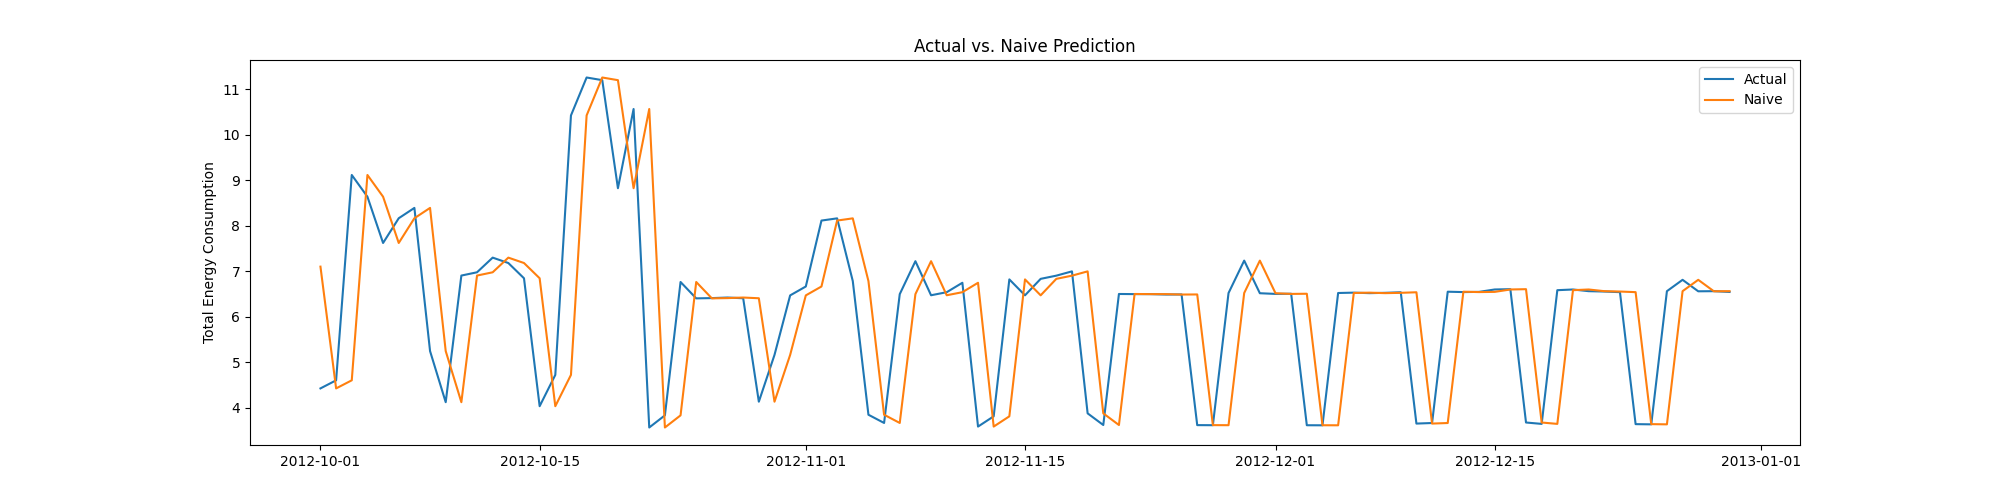

In [16]:
# Naive
fig, ax = plt.subplots(figsize=(20, 5))
# df_predict.plot(kind='line', ax=ax)
ax.plot(df_predict.index, df_predict['Actual'], label='Actual')
ax.plot(df_predict.index, df_predict['Naive'], label='Naive')
ax.set_title('Actual vs. Naive Prediction')
ax.set_ylabel('Total Energy Consumption')
ax.legend()
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

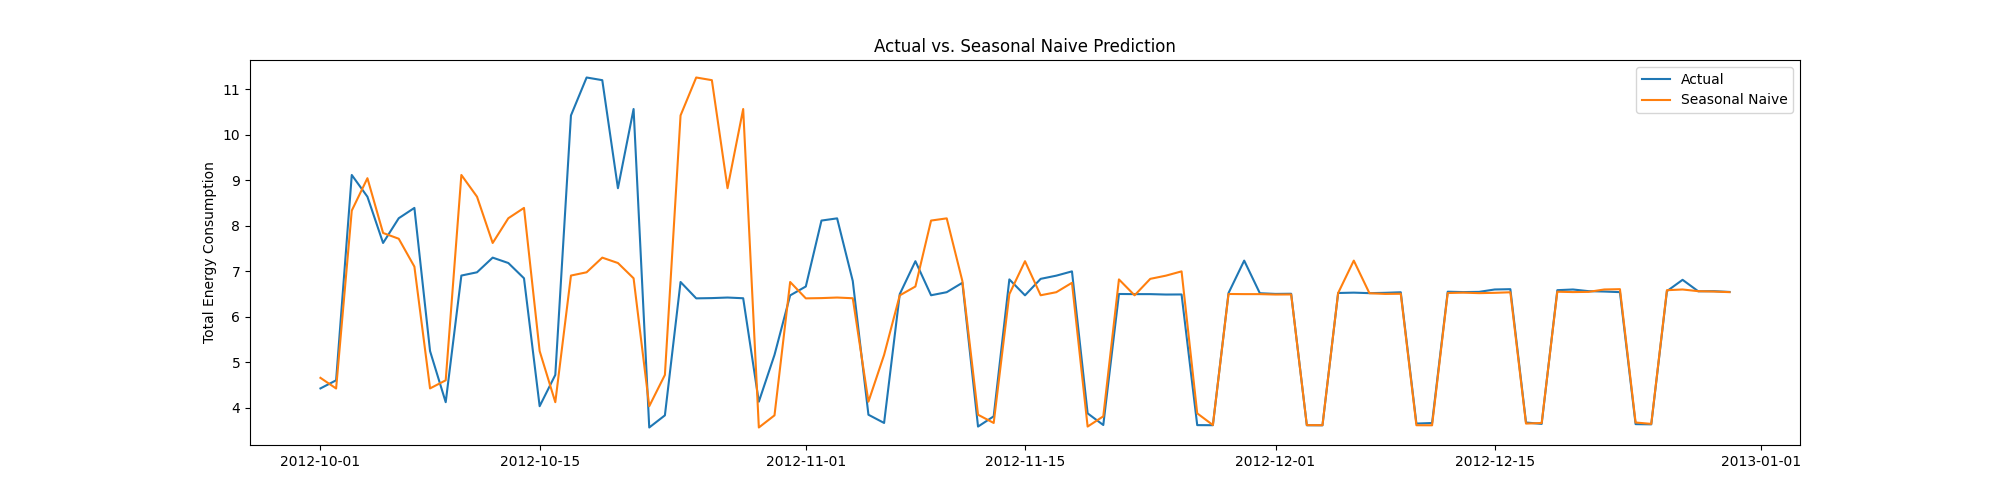

In [17]:
# Seasonal Naive
fig, ax = plt.subplots(figsize=(20, 5))
# df_predict.plot(kind='line', ax=ax)
ax.plot(df_predict.index, df_predict['Actual'], label='Actual')
ax.plot(df_predict.index, df_predict['Seasonal Naive'], label='Seasonal Naive')
ax.set_title('Actual vs. Seasonal Naive Prediction')
ax.set_ylabel('Total Energy Consumption')
ax.legend()
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

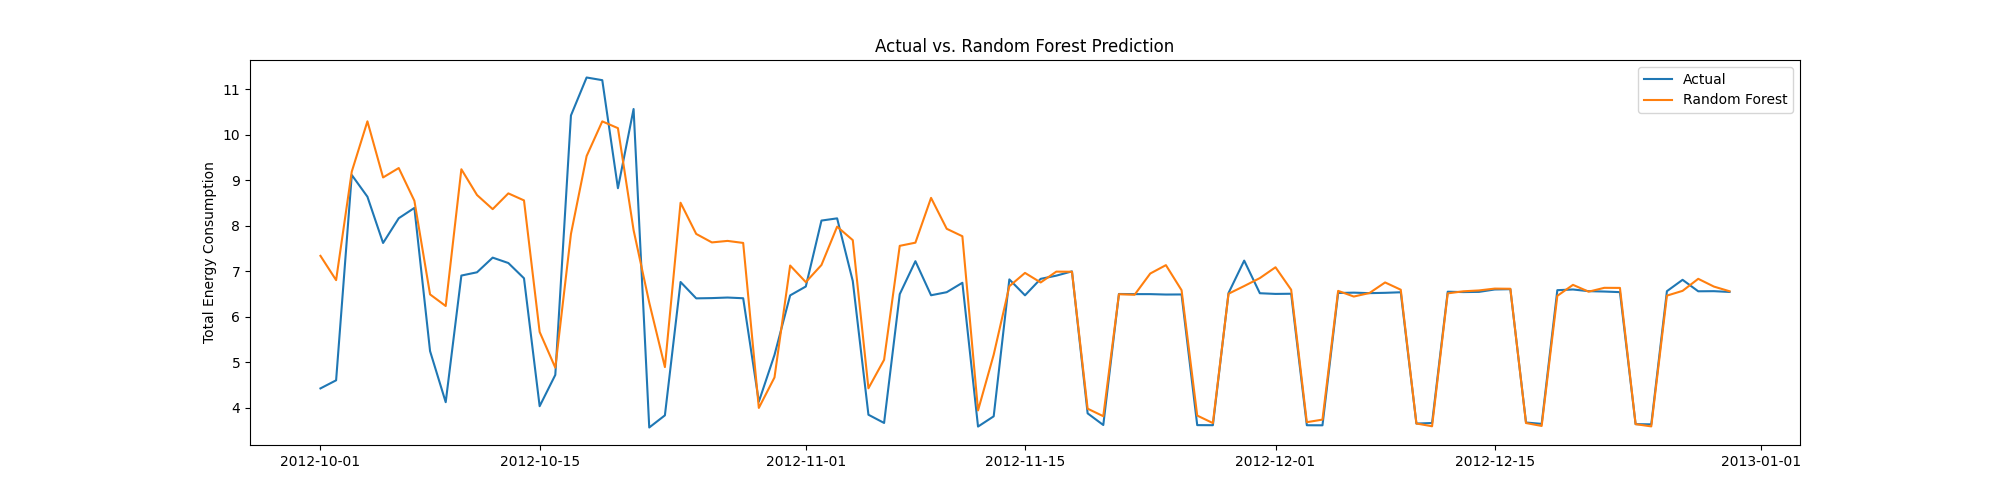

In [18]:
# Random Forest
fig, ax = plt.subplots(figsize=(20, 5))
# df_predict.plot(kind='line', ax=ax)
ax.plot(df_predict.index, df_predict['Actual'], label='Actual')
ax.plot(df_predict.index, df_predict['Random Forest'], label='Random Forest')
ax.set_title('Actual vs. Random Forest Prediction')
ax.set_ylabel('Total Energy Consumption')
ax.legend()
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

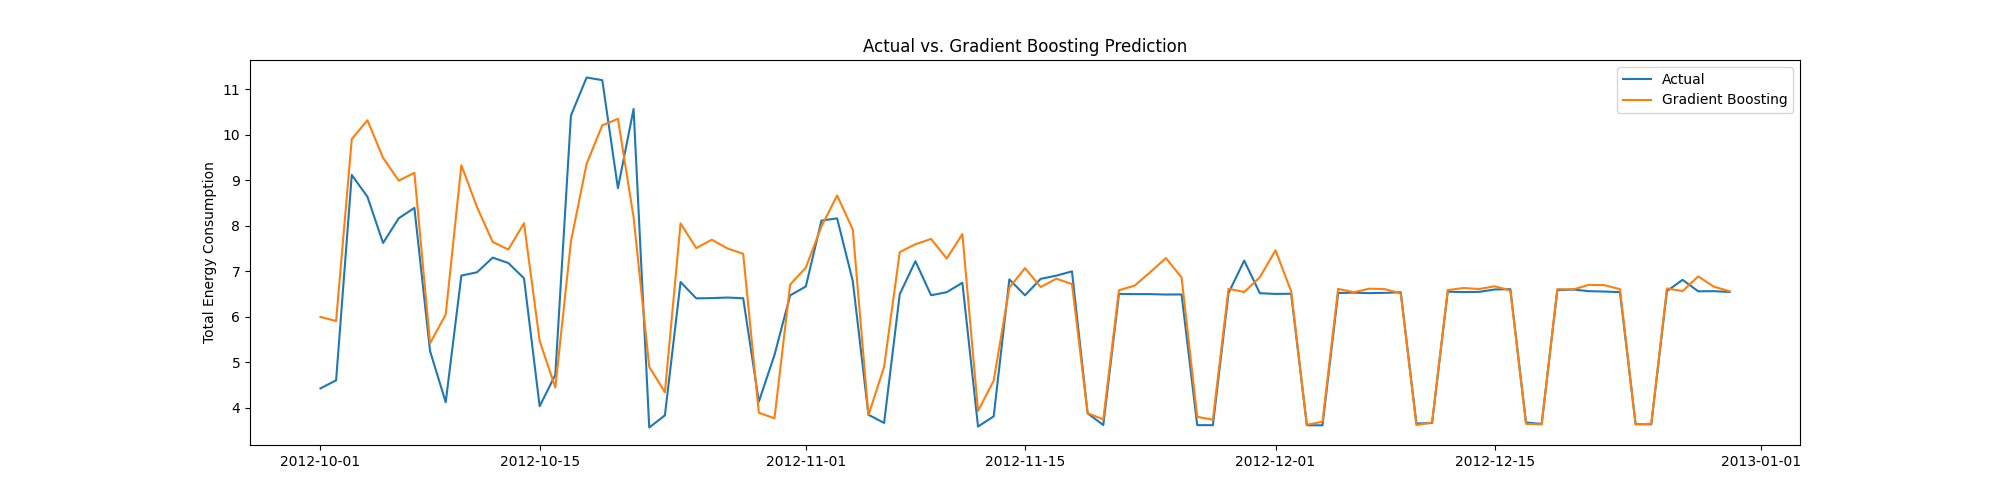

In [19]:
# Gradient Boosting
fig, ax = plt.subplots(figsize=(20, 5))
# df_predict.plot(kind='line', ax=ax)
ax.plot(df_predict.index, df_predict['Actual'], label='Actual')
ax.plot(df_predict.index, df_predict['Gradient Boosting'], label='Gradient Boosting')
ax.set_title('Actual vs. Gradient Boosting Prediction')
ax.set_ylabel('Total Energy Consumption')
ax.legend()
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

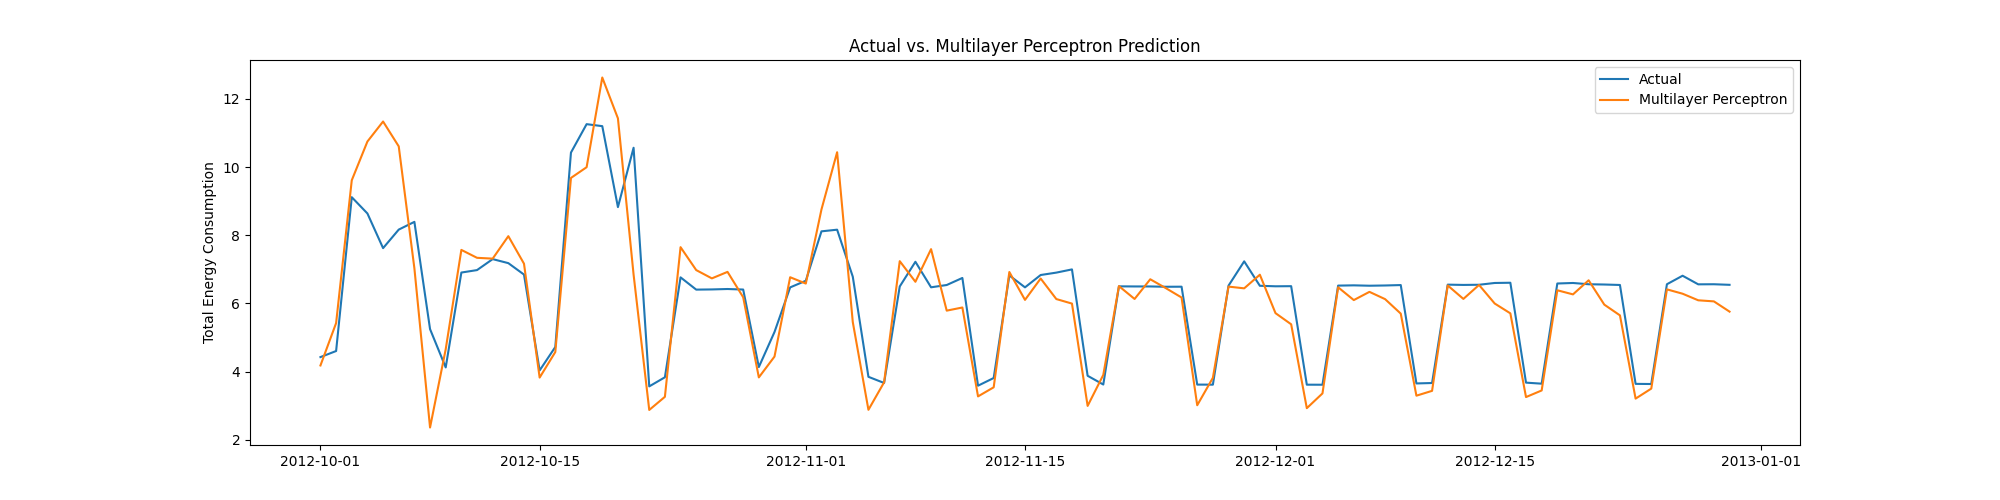

In [20]:
# Multilayer Perceptron
fig, ax = plt.subplots(figsize=(20, 5))
# df_predict.plot(kind='line', ax=ax)
ax.plot(df_predict.index, df_predict['Actual'], label='Actual')
ax.plot(df_predict.index, df_predict['Multilayer Perceptron'], label='Multilayer Perceptron')
ax.set_title('Actual vs. Multilayer Perceptron Prediction')
ax.set_ylabel('Total Energy Consumption')
ax.legend()
%matplot plt

In [21]:
# Append the new model score to the results dataframe
df_results = pd.DataFrame({'Model': [], 'MAE': [], 'MAPE': []})
for col in df_predict.columns[1:]:
    model_mae = mean_absolute_error(df_predict['Actual'], df_predict[col])
    model_mape = mean_absolute_percentage_error(df_predict['Actual'], df_predict[col])
    new_row = {'Model': col, 'MAE': model_mae, 'MAPE': model_mape}
    df_results = df_results.append(new_row, ignore_index=True)
df_res_mae = df_results.sort_values(by='MAE', ascending=False)
df_res_mape = df_results.sort_values(by='MAPE', ascending=False)
print(df_results)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                   Model       MAE      MAPE
0                  Naive  1.125788  0.213960
1         Seasonal Naive  0.778227  0.114627
2          Random Forest  0.683774  0.115452
3      Gradient Boosting  0.592424  0.094606
4  Multilayer Perceptron  0.674250  0.105309

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

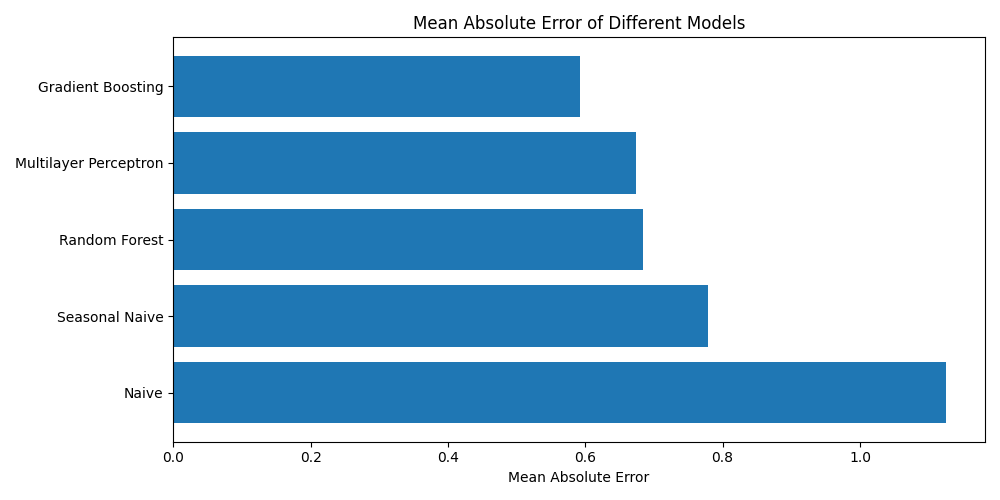

In [22]:
# Plot MAE of Different Models
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(df_res_mae['Model'], df_res_mae['MAE'])
ax.set_title('Mean Absolute Error of Different Models')
ax.set_xlabel('Mean Absolute Error')
plt.tight_layout()
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

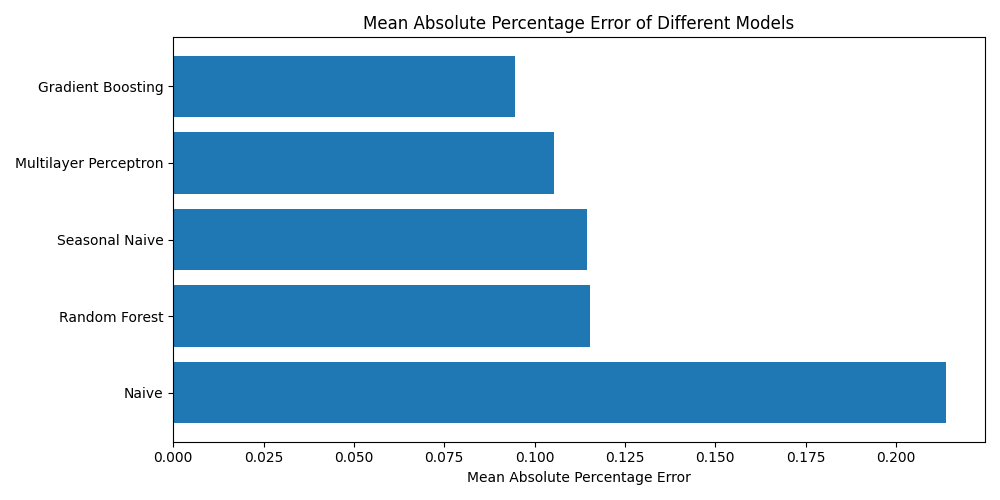

In [23]:
# Plot MAPE of Different Models
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(df_res_mape['Model'], df_res_mape['MAPE'])
ax.set_title('Mean Absolute Percentage Error of Different Models')
ax.set_xlabel('Mean Absolute Percentage Error')
plt.tight_layout()
%matplot plt

# Save to Pickle

In [24]:
# Upload pickle file to S3 bucket
s3 = boto3.client('s3')
bucket_name = 'bdcc2023-fgarcia-project'

# Save final dataframe to be predicted
file_name = 'df_final_school.pkl'
df_final.to_pickle(file_name)
s3.upload_file(file_name, bucket_name, file_name)

# Save model predictions
file_name = 'df_predict_school.pkl'
df_predict.to_pickle(file_name)
s3.upload_file(file_name, bucket_name, file_name)

# Save model evaluation
file_name = 'df_results_school.pkl'
df_results.to_pickle(file_name)
s3.upload_file(file_name, bucket_name, file_name)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Save to CSV

In [25]:
# Save DataFrame as CSV file locally then upload to S3 bucket (predictions)
df_predict.to_csv('df_predict_school.csv', index=False)
s3.upload_file('df_predict_school.csv', bucket_name, 'df_predict_school.csv')

# Save DataFrame as CSV file locally then upload to S3 bucket (results)
df_results.to_csv('df_results_school.csv', index=False)
s3.upload_file('df_results_school.csv', bucket_name, 'df_results_school.csv')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…